In [1]:
# Dataset testing
import h5py

# curr_dir = os.path.dirname(os.path.abspath(__file__))
#parent_dir = os.path.dirname(curr_dir)
#sys.path.append(parent_dir)

file_path = "../data/processed/concatenated_data.hdf5"

with h5py.File(file_path, "r") as f:
    # Print all the keys inside the dataset (actions, infos, etc.)
    print("Keys in the dataset:", list(f["concatenated_data"].keys()))

    data = f["concatenated_data"]
    actions = data["actions"][:]
    observations = data["observations"][:]
    rewards_to_go = data["rewards_to_go"][:]
    time_to_go = data["time_to_go"][:]


print(f"Actions shape: {actions.shape}")
print(f"Observations shape: {observations.shape}")
print(f"Rewards to go shape: {rewards_to_go.shape}")
print(f"Time to go shape: {time_to_go.shape}")


Keys in the dataset: ['actions', 'observations', 'rewards_to_go', 'time_to_go']
Actions shape: (999382, 8)
Observations shape: (999382, 105)
Rewards to go shape: (999382,)
Time to go shape: (999382,)


In [2]:
import torch.nn as nn
import torch

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size//2) 
        self.fc4 = nn.Linear(hidden_size//2, hidden_size//4)  
        self.fc5 = nn.Linear(hidden_size//4, output_size)  
        self.relu = nn.ReLU()  # ReLU activation function

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = torch.tanh(x)  # Enforces the action range between -1 and 1
        return x 

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

# Reshape rewards_to_go and time_to_go to be 2D with shape (1000, 1)
rewards_to_go = rewards_to_go.reshape(-1, 1)
time_to_go = time_to_go.reshape(-1, 1)

X = np.concatenate((observations, rewards_to_go, time_to_go), axis=-1)
y = actions  

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=42)
print(f"Train-test split created: {len(X_train)} train samples, {len(X_test)} test samples, {len(X_val)} validation samples.")

X shape: (999382, 107)
y shape: (999382, 8)
Train-test split created: 809498 train samples, 99939 test samples, 89945 validation samples.


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert the numpy data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)



train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch.optim as optim
from tqdm.auto import tqdm  # Importing the tqdm notebook version
from zeus.monitor import ZeusMonitor

# Model initialization
input_size = 105 + 2  # s_t + d_r and d_t
hidden_size = 256
output_size = 8  
model = NeuralNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

monitor = ZeusMonitor()

# Loss function and optimizer
loss_fn = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

val_losses = []
train_losses = []

smallest_val_loss = float('inf')
patience = 2 

checkpoint_path = "best_nn.pth"

# Training loop
epochs = 20
for epoch in range(epochs):
    #monitor.begin_window("epoch")
    model.train()
    train_loss = 0.0
    
    # Use tqdm to show progress bar for training loop
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs} Training", unit="batch") as pbar:
        # TRAINING
        for inputs, labels in train_loader:
            monitor.begin_window("step")
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
            pbar.set_postfix(train_loss=train_loss/((pbar.n)+1))  # Show average loss so far
            pbar.update(1)  # Update the progress bar
            
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # EVALUATION
    model.eval()
    val_loss = 0.0
    
    # Use tqdm to show progress bar for validation loop
    with tqdm(total=len(val_loader), desc=f"Epoch {epoch+1}/{epochs} Validation", unit="batch") as pbar:
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                pbar.set_postfix(val_loss=val_loss/((pbar.n)+1))  # Show average loss so far
                pbar.update(1)

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    

    #mes = monitor.end_window("epoch")
    #print(f"Epoch {epoch} consumed {mes.time} s and {mes.total_energy} J.")

    # Early stopping
    if val_loss < smallest_val_loss:
        patience = 2
        smallest_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_path)
    else:
        patience -= 1

    if patience == 0:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # Print statistics
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

[2025-03-10 13:29:34,047] [zeus.device.gpu.nvidia](nvidia.py:47) pynvml is available and initialized.
[2025-03-10 13:29:34,059] [zeus.device.cpu.rapl](rapl.py:137) RAPL is not supported on this CPU.
[2025-03-10 13:29:34,060] [zeus.monitor.energy](energy.py:209) Monitoring GPU indices [0].
[2025-03-10 13:29:34,060] [zeus.monitor.energy](energy.py:210) Monitoring CPU indices []


RuntimeError: PyTorch is available but does not have CUDA support.

In [40]:
# Testing loop
model.eval()  # Set the model to evaluation mode
total_loss = 0.0
with torch.no_grad():  # No gradient calculation for evaluation
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

test_loss = total_loss / len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.1815


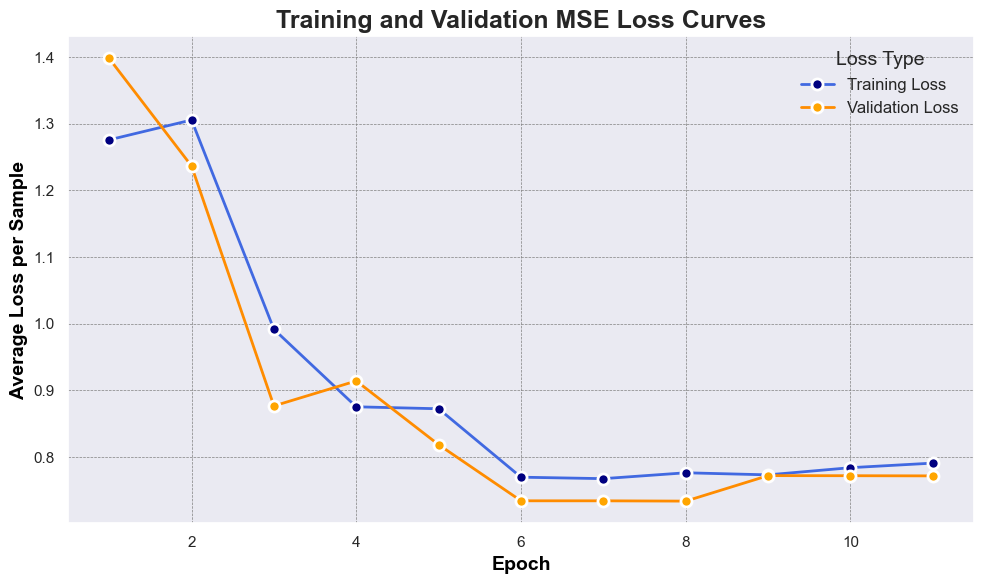

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming train_losses and val_losses are given as lists or arrays
train_losses = np.array(train_losses)  # Replace with your actual data
val_losses = np.array(val_losses)  # Replace with your actual data

# Generate a DataFrame for better plotting with seaborn
epochs = np.arange(1, len(train_losses) + 1)  # Create an array of epoch numbers

data = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': train_losses,
    'Validation Loss': val_losses
})

# Set the seaborn style to 'darkgrid' for a more aesthetic background
sns.set(style="darkgrid", palette="muted")

# Create the plot
plt.figure(figsize=(10, 6))

# Plot Training Loss with a nice color
sns.lineplot(data=data, x='Epoch', y='Training Loss', label='Training Loss', 
             color='royalblue', lw=2, marker='o', markersize=8, markerfacecolor='navy', markeredgewidth=2)

# Plot Validation Loss with a contrasting color
sns.lineplot(data=data, x='Epoch', y='Validation Loss', label='Validation Loss', 
             color='darkorange', lw=2, marker='o', markersize=8, markerfacecolor='orange', markeredgewidth=2)

# Add title and labels with an aesthetic font
plt.title('Training and Validation MSE Loss Curves', fontsize=18, weight='bold')
plt.xlabel('Epoch', fontsize=14, weight='bold', color='black')
plt.ylabel('Average Loss per Sample', fontsize=14, weight='bold', color='black')

# Add gridlines with a lighter color for better visibility
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Add legend with a custom position and style
plt.legend(title='Loss Type', loc='upper right', fontsize=12, title_fontsize=14, frameon=False)

# Make sure the layout fits nicely
plt.tight_layout()

# Show the plot
plt.show()
